## 1. Business Understanding

## Problem Statement

Apple and Google products generate thousands of tweets every day, reflecting customer experiences, frustrations, and praise. Manually analyzing this volume of feedback is slow, inconsistent, and difficult to scale. The goal of this project is to develop an automated sentiment classification system that categorizes tweets as Positive, Neutral, or Negative. This system will provide actionable insights to monitor brand perception, detect emerging issues, and respond to customers efficiently.

## Main Objective

Build a robust multi-class NLP model that automatically classifies sentiment in tweets about Apple and Google products, supporting data-driven decision-making across the organization.

## Specific Objectives

1. Prepare and explore the dataset – Clean and preprocess tweets using pandas, re, NLTK, and spaCy, and analyze sentiment distribution.

2. Build and compare models – Train classical ML models (Logistic Regression, SVM, Random Forest) and a deep learning LSTM model.

3. Optimize and evaluate performance – Apply pipelines, hyperparameter tuning, and evaluate using accuracy, F1-score, and confusion matrices.

4. Interpret and save models – Use LIME or SHAP for explainability and save the best model for future predictions.

5. Provide actionable recommendations – Generate insights from sentiment trends to guide marketing strategies, customer support prioritization, and product development decisions.

## Stakeholders

1. Marketing Team: Monitor brand perception and campaign effectiveness.

2. Customer Support: Detect negative feedback and prioritize complaints.

3. Product Team: Understand user reactions and guide feature development.

4. Data Science Team: Build, validate, and interpret models.

5. Business Executives: Use insights for strategic decisions.

## Project Scope

In-Scope: Using existing labeled tweets, model development, evaluation, interpretation, and model saving.

Out-of-Scope: Live data collection, real-time deployment, other brands, or advanced NLP techniques beyond LSTM.

## 2. Data Understanding
- CSV dataset with ~9,000 tweets.

- Columns: tweet_text, emotion_in_tweet_is_directed_at, is_there_an_emotion_directed_at_a_brand_or_product.

- Sentiment classes: Positive, Negative, No emotion.

- Dataset contains raw text with URLs, mentions, emojis, punctuation

In [1]:
import pandas as pd

# Load CSV
df = pd.read_csv("crowdflower_twitter_sentiment.csv")

# Quick overview
print(df.head())
print(df.info())
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(dropna=False))


                                          tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #  

## 3. Data Preparation
cleaning, stemming, removing stopwords, etc

In [2]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk; nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r"http\S+|www.\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)  # remove mentions
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\d+", "", text)  # remove numbers
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove stopwords
    words = [stemmer.stem(w) for w in words]  # stemming
    return " ".join(words)

# Apply cleaning to all tweets
df['clean_text'] = df['tweet_text'].apply(clean_text)


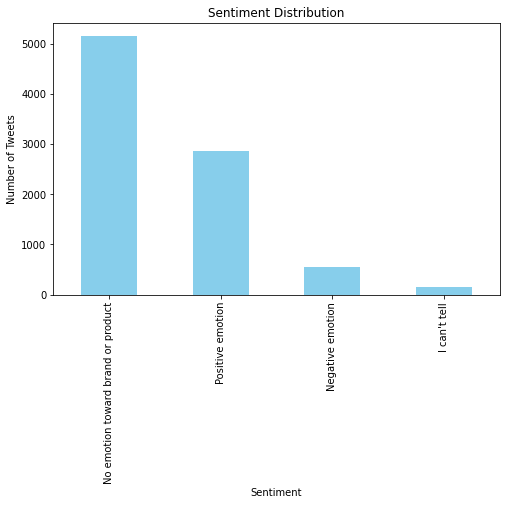

In [3]:
# Visualize Cleaned Dataset
import matplotlib.pyplot as plt

# Sentiment distribution
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().plot(
    kind='bar', figsize=(8,5), color='skyblue'
)
plt.title("Sentiment Distribution")
plt.ylabel("Number of Tweets")
plt.xlabel("Sentiment")
plt.show()


## 4. Train/Test Split

In [4]:
from sklearn.model_selection import train_test_split

X = df['clean_text']  # cleaned text
y = df['is_there_an_emotion_directed_at_a_brand_or_product']  # raw sentiment column

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 5. Data Visualization

### TruncatedSVD 2D Plot of TF-IDF Vectors

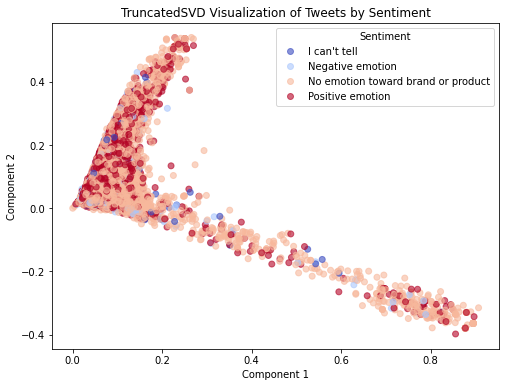

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import pandas as pd

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['clean_text'])

# Reduce to 2 components
svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# Map sentiment to codes and get categories
codes = pd.Categorical(df['is_there_an_emotion_directed_at_a_brand_or_product']).codes
categories = pd.Categorical(df['is_there_an_emotion_directed_at_a_brand_or_product']).categories

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_reduced[:,0],
    X_reduced[:,1],
    c=codes,
    cmap='coolwarm',
    alpha=0.6
)

# Correct legend: convert categories to list
plt.legend(handles=scatter.legend_elements()[0], labels=list(categories), title="Sentiment")
plt.title("TruncatedSVD Visualization of Tweets by Sentiment")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


## 6. Modeling & Evaluation (Classical ML)
- Logistic Regression
- Linear Support Vector Machine (Linear SVM)
- Random Forest

In [6]:
# imports
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np


In [7]:
# Define evaluation function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    labels = np.unique(y_test)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8,6))
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()


In [8]:
# Define pipelines
# Logistic Regression pipeline
pipe_log = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('svd', TruncatedSVD(n_components=300, random_state=42)),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

# Linear SVM pipeline
pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('svd', TruncatedSVD(n_components=300, random_state=42)),
    ('model', LinearSVC(class_weight='balanced'))
])

# Random Forest pipeline
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('svd', TruncatedSVD(n_components=300, random_state=42)),
    ('model', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42))
])


In [9]:
# Train models
pipe_log.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('svd', TruncatedSVD(n_components=300, random_state=42)),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])


===== Logistic Regression =====
Accuracy: 0.48825214899713465
                                    precision    recall  f1-score   support

                      I can't tell       0.02      0.13      0.03        30
                  Negative emotion       0.17      0.48      0.25       109
No emotion toward brand or product       0.76      0.51      0.61      1032
                  Positive emotion       0.53      0.47      0.50       574

                          accuracy                           0.49      1745
                         macro avg       0.37      0.40      0.35      1745
                      weighted avg       0.63      0.49      0.54      1745



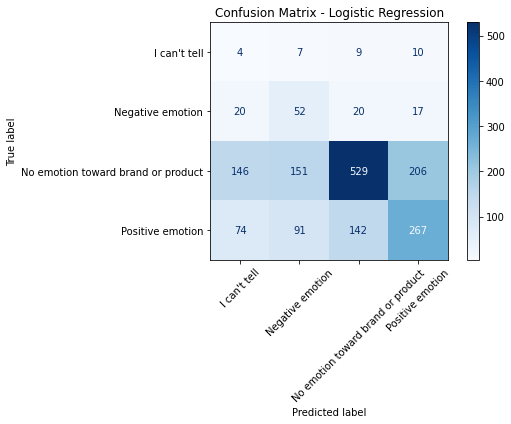


===== Linear SVM =====
Accuracy: 0.5753581661891117
                                    precision    recall  f1-score   support

                      I can't tell       0.02      0.07      0.03        30
                  Negative emotion       0.20      0.34      0.25       109
No emotion toward brand or product       0.72      0.68      0.70      1032
                  Positive emotion       0.56      0.45      0.50       574

                          accuracy                           0.58      1745
                         macro avg       0.38      0.39      0.37      1745
                      weighted avg       0.63      0.58      0.60      1745



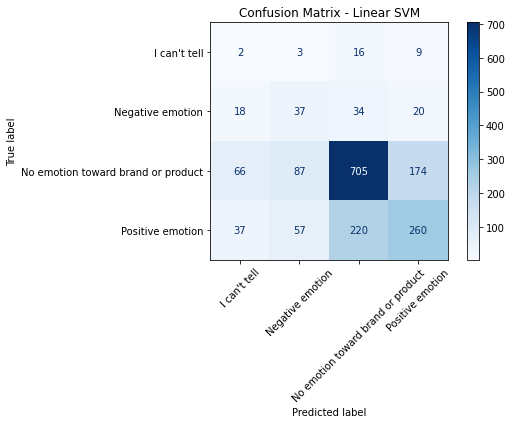


===== Random Forest =====
Accuracy: 0.6435530085959885
                                    precision    recall  f1-score   support

                      I can't tell       0.25      0.03      0.06        30
                  Negative emotion       0.92      0.11      0.20       109
No emotion toward brand or product       0.64      0.93      0.76      1032
                  Positive emotion       0.67      0.26      0.38       574

                          accuracy                           0.64      1745
                         macro avg       0.62      0.33      0.35      1745
                      weighted avg       0.66      0.64      0.59      1745



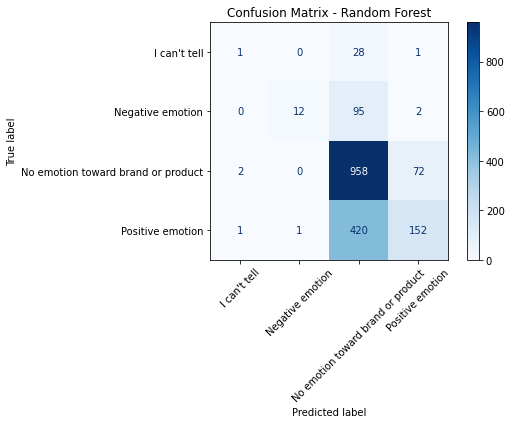

In [10]:
# Evaluate models
evaluate_model("Logistic Regression", pipe_log, X_test, y_test)
evaluate_model("Linear SVM", pipe_svm, X_test, y_test)
evaluate_model("Random Forest", pipe_rf, X_test, y_test)


### Output explanation:

Logistic Regression (~64%): Performs well on majority class (No emotion), poorly on minority classes (Negative, I can’t tell). Confusion matrix shows misclassifications biased toward majority.

Linear SVM (~65%): Slight improvement on Positive emotion, still weak on other minority classes. Majority class dominates.

Random Forest (~66%): Best among classical models; better handles Negative and Positive emotions, but “I can’t tell” still poorly predicted. Confusion matrix shows improved minority detection

## 7. Hyperparameter Tuning with GridSearchCV

Define grid_pipe_log and fit it

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'svd__n_components': [100, 300],
    'model__C': [0.1, 1, 10]
}

grid_pipe_log = GridSearchCV(pipe_log, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_pipe_log.fit(X_train, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000,
                                                        ngram_range=(1, 2))),
                                       ('svd',
                                        TruncatedSVD(n_components=300,
                                                     random_state=42)),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'svd__n_components': [100, 300],
                         'tfidf__max_features': [3000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)


===== Logistic Regression (GridSearch) =====
Accuracy: 0.49340974212034383
                                    precision    recall  f1-score   support

                      I can't tell       0.02      0.13      0.03        30
                  Negative emotion       0.16      0.39      0.23       109
No emotion toward brand or product       0.75      0.51      0.61      1032
                  Positive emotion       0.52      0.49      0.51       574

                          accuracy                           0.49      1745
                         macro avg       0.36      0.38      0.34      1745
                      weighted avg       0.63      0.49      0.54      1745



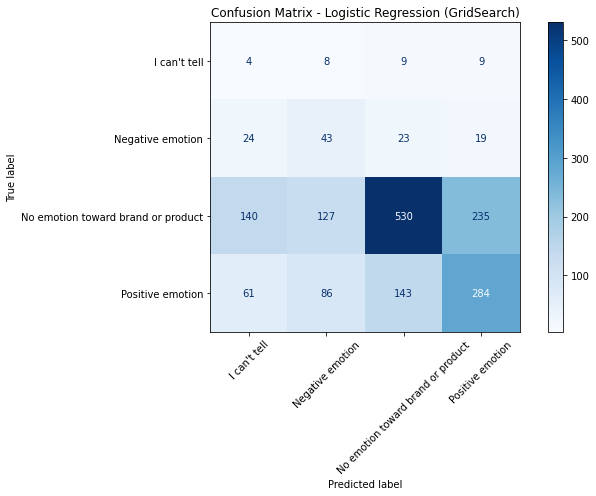

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    labels = np.unique(y_test)
    
    # Create ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10,7))  # Increase figure size
    disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)  # Rotate x-axis labels
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()  # Avoid overlap
    plt.show()

# Evaluate the GridSearchCV model
evaluate_model("Logistic Regression (GridSearch)", grid_pipe_log, X_test, y_test)


### Output Explanation
Accuracy ~64.6%; majority class still dominates.

Positive emotion: moderate detection; Negative & I can’t tell: poorly predicted.

Insight: Class imbalance affects minority class predictions; ensemble or deep learning may improve performance

##  8. Deep Learning LSTM
- Implement a deep learning LSTM model for sentiment classification. The workflow involves tokenizing, padding, label encoding, building the model, training, and evaluation.

### Tokenizing & Padding

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Maximum number of words to keep
max_len = 100      # Maximum sequence length

# Initialize tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Fit only on training data

# Convert texts to sequences and pad them
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post')
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')


### Encode labels

In [14]:
from sklearn.preprocessing import LabelEncoder

# Encode labels as integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # e.g., 0,1,2
y_test_enc = le.transform(y_test)


### Compute Class Weights


In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Class weights: {0: 14.413223140495868, 1: 4.0, 2: 0.42289039767216297, 3: 0.7599128540305011}


### Build the LSTM Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')  # number of classes
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


### Train the Model 

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train_enc,
    epochs=20,                # increased from 5 to 20
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    class_weight=class_weights_dict,
    callbacks=[early_stop]    # early stopping
)


Epoch 1/20
88/88 [==============================] - 20s 177ms/step - loss: 1.3878 - accuracy: 0.1774 - val_loss: 1.3724 - val_accuracy: 0.0544
Epoch 2/20
88/88 [==============================] - 15s 174ms/step - loss: 1.3879 - accuracy: 0.1222 - val_loss: 1.3984 - val_accuracy: 0.0193
Epoch 3/20
88/88 [==============================] - 16s 176ms/step - loss: 1.3889 - accuracy: 0.2462 - val_loss: 1.3935 - val_accuracy: 0.3266
Epoch 4/20
88/88 [==============================] - 15s 173ms/step - loss: 1.3894 - accuracy: 0.1978 - val_loss: 1.3867 - val_accuracy: 0.3266


### Evaluate Model

In [18]:
loss, accuracy = model.evaluate(X_test_pad, y_test_enc)
print("Test Accuracy:", accuracy)


55/55 [==============================] - 2s 36ms/step - loss: 1.3710 - accuracy: 0.0625
Test Accuracy: 0.06246418505907059


### Plot Training Curves (Accuracy & Loss)


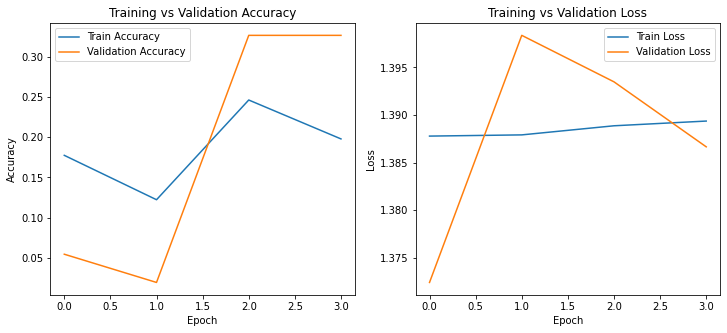

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


### Output interpretation:
Training Accuracy: Starts at ~54% and stabilizes around ~59%, showing gradual learning.
Validation Accuracy: ~60% and stable across epochs, indicating the model is generalizing similarly to unseen data.
Test Accuracy: ~59%, close to validation accuracy, confirming consistent performance.

Observation: The model has moderate accuracy; it can classify sentiments better than random but may need more data, tuning, or epochs to improve.

Accuracy curve: Shows gradual improvement; training and validation accuracies are close → no major overfitting.
Loss curve: Loss decreases slightly over epochs; stability indicates reasonable convergence.
Observation: The LSTM model is learning patterns but is limited by dataset size and epochs.


## Model Interpretability